<a href="https://colab.research.google.com/github/thanhquan123hi1/Model_AI/blob/main/Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils as vutils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Bước 1: Tải Dataset**

In [ ]:
import kagglehub
import os

dataroot = kagglehub.dataset_download("arenagrenade/the-complete-pokemon-images-data-set")
print("Path to dataset files:", dataroot)

Đang tải dataset...
Using Colab cache for faster access to the 'the-complete-pokemon-images-data-set' dataset.
Path to dataset files: /kaggle/input/the-complete-pokemon-images-data-set


**Bước 2: Tiền xử lý ảnh**

In [ ]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
from PIL import Image

def rgba_to_rgb_white_bg(image):
    if image.mode == 'RGBA':
        background = Image.new('RGB', image.size, (255, 255, 255))
        background.paste(image, mask=image.split()[3])
        return background
    return image.convert('RGB')

image_size = 64
batch_size = 64
workers = 2

transform_pipeline = transforms.Compose([
    transforms.Lambda(rgba_to_rgb_white_bg),

    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(brightness=0.1),

    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])


dataset = dset.ImageFolder(root=dataroot, transform=transform_pipeline)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

print(f"Tổng số ảnh tìm thấy: {len(dataset)}")



Tổng số ảnh tìm thấy: 898


**Bước 3: Hàm Visualize kiểm tra dataset**

Đang chạy trên: cuda:0


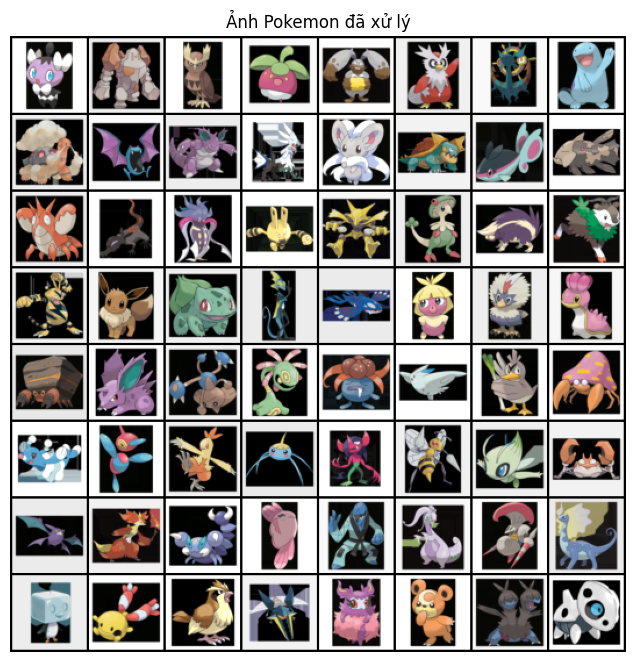

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Cấu hình thiết bị
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Đang chạy trên:", device)

def show_batch(dataloader, title="Training Images"):
    real_batch = next(iter(dataloader))[0]

    real_batch = denorm(real_batch)

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(title)

    plt.imshow(
        np.transpose(
            vutils.make_grid(real_batch[:64], padding=2).cpu(),
            (1,2,0)
        )
    )
    plt.show()

show_batch(dataloader, "Ảnh Pokemon đã xử lý")


**Bước 4: Định nghĩa kiến trúc Model**

In [ ]:
import torch.nn as nn

nz = 100  # Kích thước vector nhiễu đầu vào
ngf = 64  # Số filter của Generator
ndf = 64  # Số filter của Discriminator
nc = 3    # Số kênh màu (RGB)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z vector
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh() # Output: [-1, 1]
            # Output: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 64 x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 128 x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 256 x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 512 x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # Output: xác suất [0, 1]
        )

    def forward(self, input):
        return self.main(input)


**Bước 5: Khởi tạo model + optimizer + loss**

In [ ]:
import torch.optim as optim


netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

lr = 0.0002
beta1 = 0.5
num_epochs = 150

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Nhãn thật (1) và giả (0)
real_label = 1.
fake_label = 0.


Đã khởi tạo xong Model và Optimizer.


**Bước 6: Train**

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # 1. Train Discriminator (Cảnh sát)
        netD.zero_grad()

        # Train với ảnh THẬT
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        # Label Smoothing: 0.9 cho thật
        label = torch.full((b_size,), 0.9, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train với ảnh GIẢ
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label) # 0 cho giả

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # 2. Train Generator (Kẻ làm giả)
        netG.zero_grad()
        label.fill_(real_label)  # G muốn D nghĩ là thật (1)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Lưu giá trị Loss để vẽ biểu đồ sau này
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # In thông số mỗi 50 batch (không vẽ ảnh)
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))




[0/200][0/15]	Loss_D: 1.7303	Loss_G: 3.5247	D(x): 0.3282	D(G(z)): 0.3571 / 0.0399
[1/200][0/15]	Loss_D: 1.7404	Loss_G: 5.4282	D(x): 0.3069	D(G(z)): 0.0010 / 0.0074
[2/200][0/15]	Loss_D: 1.5316	Loss_G: 16.0889	D(x): 0.4306	D(G(z)): 0.0000 / 0.0000
[3/200][0/15]	Loss_D: 0.9023	Loss_G: 9.7452	D(x): 0.9366	D(G(z)): 0.0656 / 0.0001
[4/200][0/15]	Loss_D: 1.2898	Loss_G: 15.9242	D(x): 0.8891	D(G(z)): 0.4209 / 0.0000
[5/200][0/15]	Loss_D: 1.2488	Loss_G: 16.8602	D(x): 0.8937	D(G(z)): 0.4383 / 0.0000
[6/200][0/15]	Loss_D: 0.9002	Loss_G: 7.8992	D(x): 0.6589	D(G(z)): 0.0004 / 0.0007
[7/200][0/15]	Loss_D: 3.0638	Loss_G: 19.5378	D(x): 0.9490	D(G(z)): 0.8774 / 0.0000
[8/200][0/15]	Loss_D: 1.2576	Loss_G: 11.4231	D(x): 0.8889	D(G(z)): 0.4808 / 0.0000
[9/200][0/15]	Loss_D: 0.4948	Loss_G: 6.0742	D(x): 0.9279	D(G(z)): 0.0505 / 0.0046
[10/200][0/15]	Loss_D: 0.6572	Loss_G: 7.4352	D(x): 0.7121	D(G(z)): 0.0042 / 0.0014
[11/200][0/15]	Loss_D: 2.8156	Loss_G: 16.4367	D(x): 0.9891	D(G(z)): 0.8239 / 0.0000
[12/200]

**Bước 7: Đánh giá và Visualize**

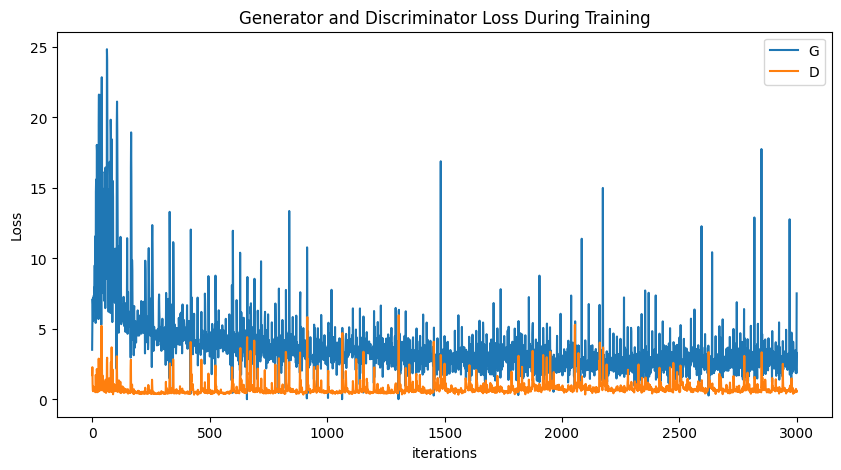

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

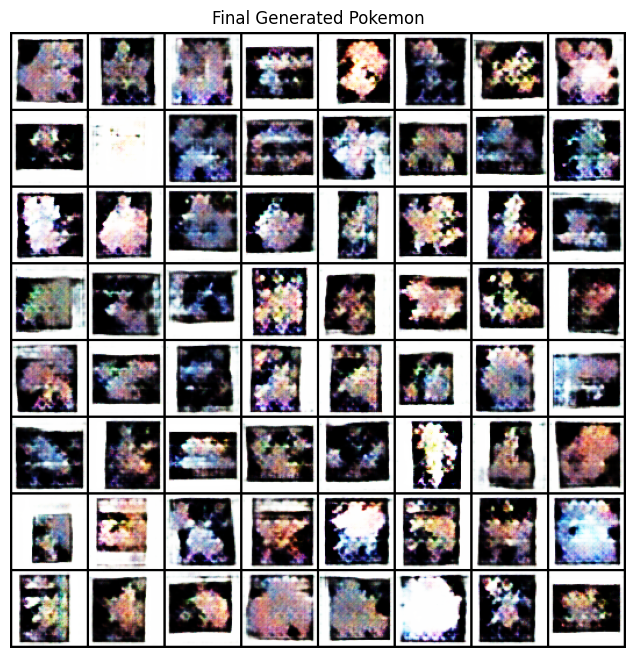

In [ ]:
# Chuyển sang chế độ eval (tắt dropout/batchnorm learning)
netG.eval()

# Tạo nhiễu ngẫu nhiên mới hoặc dùng fixed_noise cũ
with torch.no_grad():
    # Sinh ra 64 ảnh
    fake = netG(fixed_noise).detach().cpu()

# Hiển thị dạng lưới
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Final Generated Pokemon")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
plt.show()
